# Adora Analysis (2017-06-28)

The goal here is to import all data from our 2017-06-28 scanning session, and format it in a [pandas](http://pandas.pydata.org/) dataframe.  We collected DICOM image data, rpos angle data and motion capture information.  Three identical scans were performed of a 9-BB phantom with a larger, central BB close to the center of rotation for tracking purposes.  Motion capture data was recorded, as was gantry angle data.

## Data Import

Start with the usual python variable definitions and import statements

In [1]:
# set `s3_access` to True to pull data from s3 storage on Amazon -- note that the s3 bucket I'm currently using migrates stuff to glacier so
# amazon access won't work at the moment.
s3_access = False

# additional global variables
base_directory = 'D:\\Data\\UWO X-ray project\\Adora\\'
date = '20170628'
debug = True

In [2]:
import os
import sys
import zipfile
import pandas as pd
from pylab import *
import matplotlib.pyplot as plt
from IPython.display import Image
from ipywidgets import IntProgress, widgets, HTML, VBox
try:
    import adora_bb_finder
except:
    pass  # ignore _transformations warning
    
# globally change plot size
matplotlib.rcParams['figure.figsize'] = [10, 4.8]

c:\users\jgill\documents\src\mv\lib\site-packages\PI\math\transformations.py:1888: UserWarning: failed to import module _transformations
  warnings.warn("failed to import module %s" % name)


Create/open an [HDF5](https://support.hdfgroup.org/HDF5/) data store and set it up to be accesible via [pandas](http://pandas.pydata.org/).

In [3]:
store = pd.HDFStore(r'D:\Data\UWO X-ray project\Adora\{date}\data_store.hd5'.format(date=date))

### Read RPos angle data

We performed three scans with angle measurements and motion capture info.  Iterate over each dataset.  We'll read from individual CSV-format files and pack them into our [HDF5](https://support.hdfgroup.org/HDF5/) store.  RPos data was recorded by Rudy on his cell phone over bluetooth to the Arduino system we've set up.  A master
device senses x-ray exposure and requests angle data whenever this occurs.  A slave device mounted in the Adora gantry digitally samples rpos angle values and reports last-recorded value when asked.

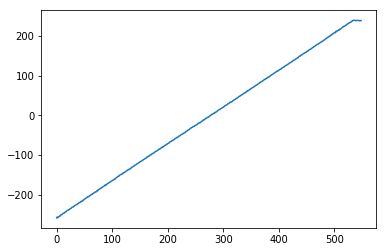

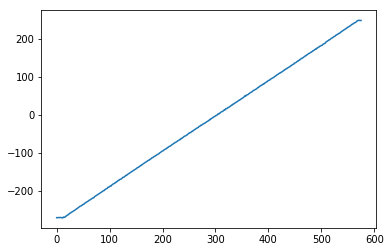

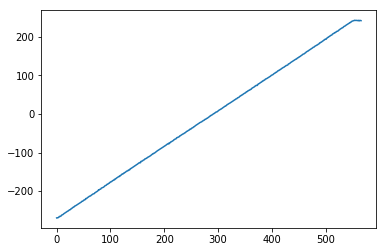

In [4]:
if s3_access:
    template = "https://s3.amazonaws.com/parallax-adora/Adora/{date}/ArduinoAngleData/scan+{scan_number}.csv"
else:
    template = r"D:\Data\UWO X-ray project\Adora\{date}\Arduino Angle data\scan {scan_number}.csv"

for i in range(3):
    label = '/adora/date_{date}/scan{scan_number}/angles'.format(date=date, scan_number=i+1) 
    if label not in store:
        store[label] = \
        pd.read_csv(template.format(date=date, scan_number=i+1),
                    names=['view', 'angle'])
store.flush()

if debug:
    for i in range(3):
        label = '/adora/date_{date}/scan{scan_number}/angles'.format(date=date, scan_number=i+1) 
        plot(store[label].view.values, store[label].angle.values); show()

### Read Motion-capture data

Okay, next let's pull in motion capture data.  The files are somewhat free-form but essentially contain tab-delimited CSV data.  We ignore the first few rows of data, process the remainder as csv, then edit column headers.  One important thing to know about the motion capture data: The vertical axis in the capture *.ts files is labelled as the 'Y1' axis. At the moment we'll assume a right handed coordinate system, which means we want to convert (Z1,X1,Y1) to (X1,Y1,Z1). Part of the column manipulation, fixes this.

In [5]:
if s3_access:
    template = "https://s3.amazonaws.com/parallax-adora/Adora/{date}/MotionCapture/adora_rotation_cube{scan_number}.ts"
else:
    template = r"D:\Data\UWO X-ray project\Adora\{date}\Motion Capture\adora_rotation_cube{scan_number}.ts"

for i in range(3):
    label = '/adora/date_{date}/scan{scan_number}/motion_capture'.format(date=date, scan_number=i+1)
    if label not in store:
        data = pd.read_csv(template.format(date=date, scan_number=i+1), \
                           sep='\t', skiprows=(0,1,2,3))
        # tweak column headers
        columns = list(data.columns)
        columns[0] = 'Frame#'; columns[1] = 'Time'
        for j in range(10):
            idx = 2 + 11*j
            columns[idx] = 'Y{}'.format(j+1); columns[idx+1] = 'Z{}'.format(j+1); columns[idx+2] = 'X{}'.format(j+1)
        data.columns = columns
        store[label] = data
store.flush()

What does our (relabeled) data look like?

In [6]:
store['/adora/date_{date}/scan1/motion_capture'.format(date=date)].iloc[:, 0:8].head()

,Frame#,Time,Y1,Z1,X1,vX1,vY1,vZ1
0,1,0.00,-242.95070,1046.91772,-378.62418,NaN,NaN,NaN
1,2,0.01,-242.96999,1046.91431,-378.59717,-0.61340,2.09961,2.81982
2,3,0.02,-242.96297,1046.95972,-378.56778,0.61493,0.12817,0.29755
3,4,0.03,-242.95769,1046.91687,-378.59122,0.14420,-2.51465,-0.55237
4,5,0.04,-242.96008,1046.90942,-378.57883,3.40881,0.01221,-2.25677


### Read data from XMALab

Next, let's process data we generated using XMALab (generated on August 11).  Rudy has found a semi-automated way to do BB tracking which simplifies things significantly.  Previously, I'd been spending significant effort to optimize a fully-automated way to track BBs, but XMALab is fast enough and good enough that this is no longer a worth-while effort.

In [7]:
def convert_xma_to_dataframe(xma_filename):
    """
    Converts fiducial tracking information from an XMALabs *.xma file to a pandas DataFrame
    """

    # open xma file (it's a zip file)
    z = zipfile.ZipFile(xma_filename, mode='r')
    namelist = z.namelist()

    # iterate over all fiducials, extract CSV file.  Convert to a pandas dataframe
    vals = []
    for num in range(10):
        label = 'Trial 1/data/Marker{:03d}points2d.csv'.format(num)
        if label in namelist:
            _file = z.open(label)
            df = pd.read_csv(_file, names=['m{}_x'.format(num), 'm{}_y'.format(num)])
            vals.append(df)            
    z.close()
    
    # concat results
    df = pd.concat(vals, axis=1)
    
    return df

def get_xma_model_coordinates(xma_filename):
    """
    Reads an XMALabs file and returns model coordinates
    """

    # open xma file (it's a zip file)
    z = zipfile.ZipFile(xma_filename, mode='r')
    _file = z.open('CalibrationObject/3DCube_framespec_9point.csv')
    df = pd.read_csv(_file, names=['X','Y','Z'], header=0) * 10.0  # convert from cm -> mm

    return df

store = pd.HDFStore(r'D:\Data\UWO X-ray project\Adora\{date}\data_store.hd5'.format(date=date))

# convert first scan (9-bb scan)
for scan_name in ('scan1', 'scan2'):
    xma_filename = os.path.join(base_directory, date, '{date}-{scan_name}.xma'.format(date=date, scan_name=scan_name))
    label = '/adora/date_{date}/{scan_name}/XMALab/measured_points'.format(date=date, scan_name=scan_name)
    df = convert_xma_to_dataframe(xma_filename)
    store[label] = df

    # get model coordinates (for scan 1)
    coords = get_xma_model_coordinates(xma_filename)
    store['/adora/date_{date}/{scan_name}/XMALab/model_points'.format(date=date, scan_name=scan_name)] = coords

store.flush()


## Data Analysis

Next, we will visualize the data that we have collected into `store`.

### Investigation of Motion Tracking Data

Let's plot various (x,y,z) sets to see what our motion tracking data looks like.  Select the scan to process in the drop-down box below:

<IPython.core.display.Javascript object>


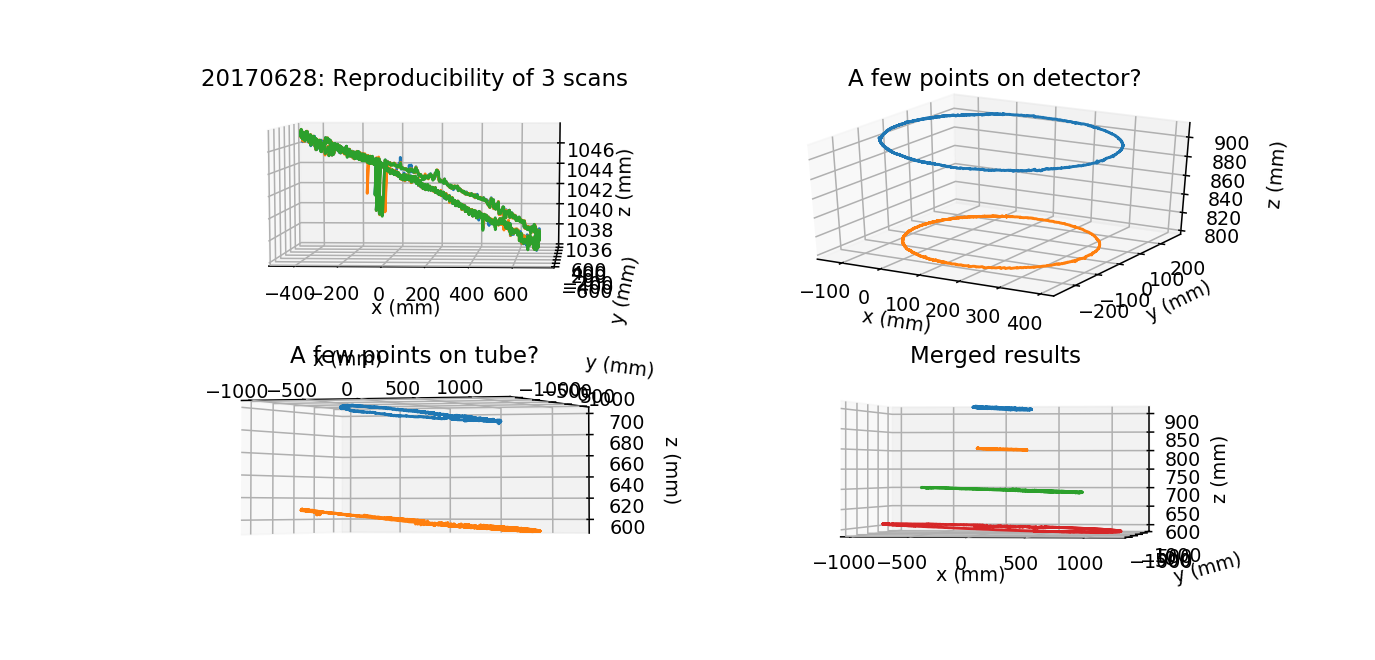

<IPython.core.display.Javascript object>


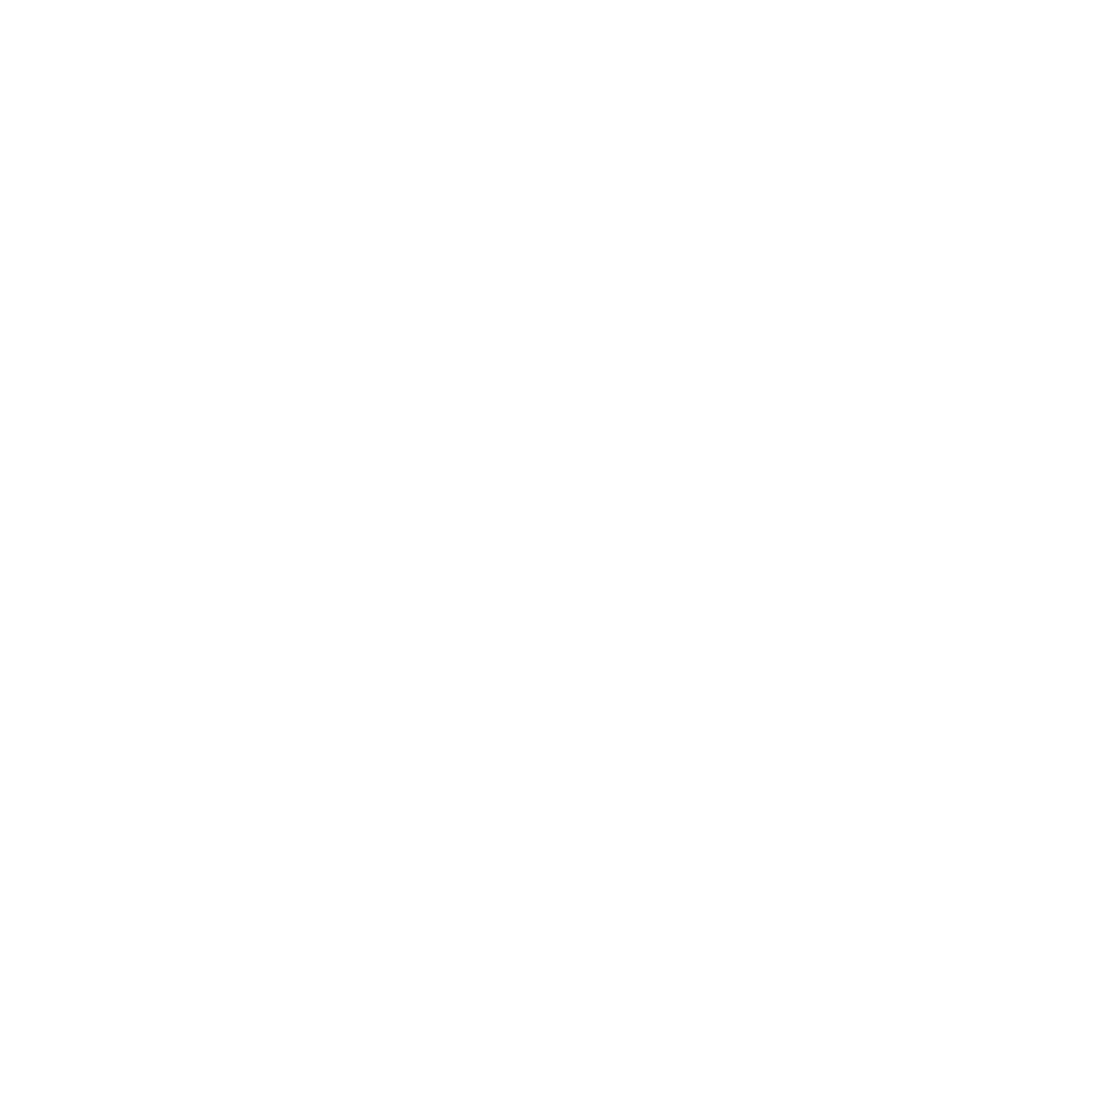

In [8]:
#####%matplotlib wx
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()

plt.figure(figsize=(8, 8))


ax1 = fig.add_subplot(221, projection='3d')
ax1.set_xlabel('x (mm)')
ax1.set_ylabel('y (mm)')
ax1.set_zlabel('z (mm)')
ax1.set_title('{date}: Reproducibility of 3 scans'.format(date=date))

data = store['/adora/date_{date}/scan{scan_number}/motion_capture'.format(date=date,scan_number=1)]
ax1.plot(data['X1'], data['Y1'], data['Z1'])

data = store['/adora/date_{date}/scan{scan_number}/motion_capture'.format(date=date,scan_number=2)]
ax1.plot(data['X1'], data['Y1'], data['Z1'])

data = store['/adora/date_{date}/scan{scan_number}/motion_capture'.format(date=date,scan_number=3)]
ax1.plot(data['X1'], data['Y1'], data['Z1'])

###############
ax2 = fig.add_subplot(222, projection='3d')
ax2.set_xlabel('x (mm)')
ax2.set_ylabel('y (mm)')
ax2.set_zlabel('z (mm)')
ax2.set_title('A few points on detector?')

data = store['/adora/date_{date}/scan{scan_number}/motion_capture'.format(date=date,scan_number=1)]
ax2.plot(data['X2'], data['Y2'], data['Z2'])
ax2.plot(data['X3'], data['Y3'], data['Z3'])

ax3 = fig.add_subplot(223, projection='3d')
ax3.set_xlabel('x (mm)')
ax3.set_ylabel('y (mm)')
ax3.set_zlabel('z (mm)')
ax3.set_title('A few points on tube?')

data = store['/adora/date_{date}/scan{scan_number}/motion_capture'.format(date=date,scan_number=1)]
ax3.plot(data['X9'], data['Y9'], data['Z9'])
ax3.plot(data['X10'], data['Y10'], data['Z10'])

ax4 = fig.add_subplot(224, projection='3d')
ax4.set_xlabel('x (mm)')
ax4.set_ylabel('y (mm)')
ax4.set_zlabel('z (mm)')
ax4.set_title('Merged results')

ax4.plot(data['X2'], data['Y2'], data['Z2'])
ax4.plot(data['X3'], data['Y3'], data['Z3'])
ax4.plot(data['X9'], data['Y9'], data['Z9'])
ax4.plot(data['X10'], data['Y10'], data['Z10'])

show()

Okay, this is awesome - we can see a z-axis deviation here clearly in the data.  This may be due to a miscalibration of the motion-capture equipment at [WOBL](http://www.fowlerkennedy.com/research/wolf-orthopaedic-biomechanics-lab-wobl/).  It might otherwise be real, in which case the Adora is sagging as it rotates about its axis.

### Calibrate scanner using Li method

Get first image points - 10 objects are tracked per frame in two dimensions.  The 10th BB is our center BB which isn't involved in the fit.  Recorded image points
are measured in mm, while the model that Rudy provided me is measured in cm.

In [9]:
scan_number = 1

image_points = store['/adora/date_{date}/scan{scan_number}/XMALab/measured_points'.format(date=date, scan_number=scan_number)].values
shape = image_points.shape
image_points.shape = (shape[0], shape[1]//2, 2)

# drop 10th BB for now
image_points = image_points[:, 0:9, :].copy()

model_points = store['/adora/date_{date}/scan{scan_number}/XMALab/model_points'.format(date=date, scan_number=scan_number)].values * 10.0  # convert cm -> mm

# original model points that appear to work. TODO: figure out why Rudy's point orientation is wrong?
model_points_2 = np.array([
            [-65.0, -65.0, 100.0],                # unique
            [ 65.0,  65.0, 130.0],                # u-12
            [ 65.0, -65.0, 130.0],                # u-3
            [-65.0, -65.0, 130.0],                # u-6
            [-65.0,  65.0, 130.0],                # u-9
            [ 65.0,  65.0,   0.0],                # b-12
            [ 65.0, -65.0,   0.0],                # b-3
            [-65.0, -65.0,   0.0],                # b-6
            [-65.0,  65.0,   0.0],                # b-9
        ], dtype='float32')  

# mapping from XMALabs data to my coordinate space
coordinate_mapping_2 = [2, 6, 1, 0, 5, 8, 4, 3, 7]

# map image data from XMALabs description to my model (version 2) above.
image_points = image_points[:, coordinate_mapping_2, :].astype('float32').copy()

# determine CT calibration values using Li method on first frame
obj = adora_bb_finder.BBFinder()
Angle, Source, t, c = obj.li_method(model_points_2, image_points[0, :, :])

# convert Source distance from pixels -> mm
Source *= 0.32

Angle,Source,t,c

(array([ 178.15710548,   75.67482708,   91.06748747]),
 array([  234.76490214,   152.46888132,  1213.52259637]),
 array([ -33.03920917,   90.49597267,  941.87998138]),
 matrix([[ 921.18466286],
         [ 202.19132397],
         [  83.40560627]]))

The value of 1211.8 represents our estimate of SDD distance, which matches the expected value of 1200 mm pretty closely.

Next, let's examine reported angle for all views

<IPython.core.display.Javascript object>


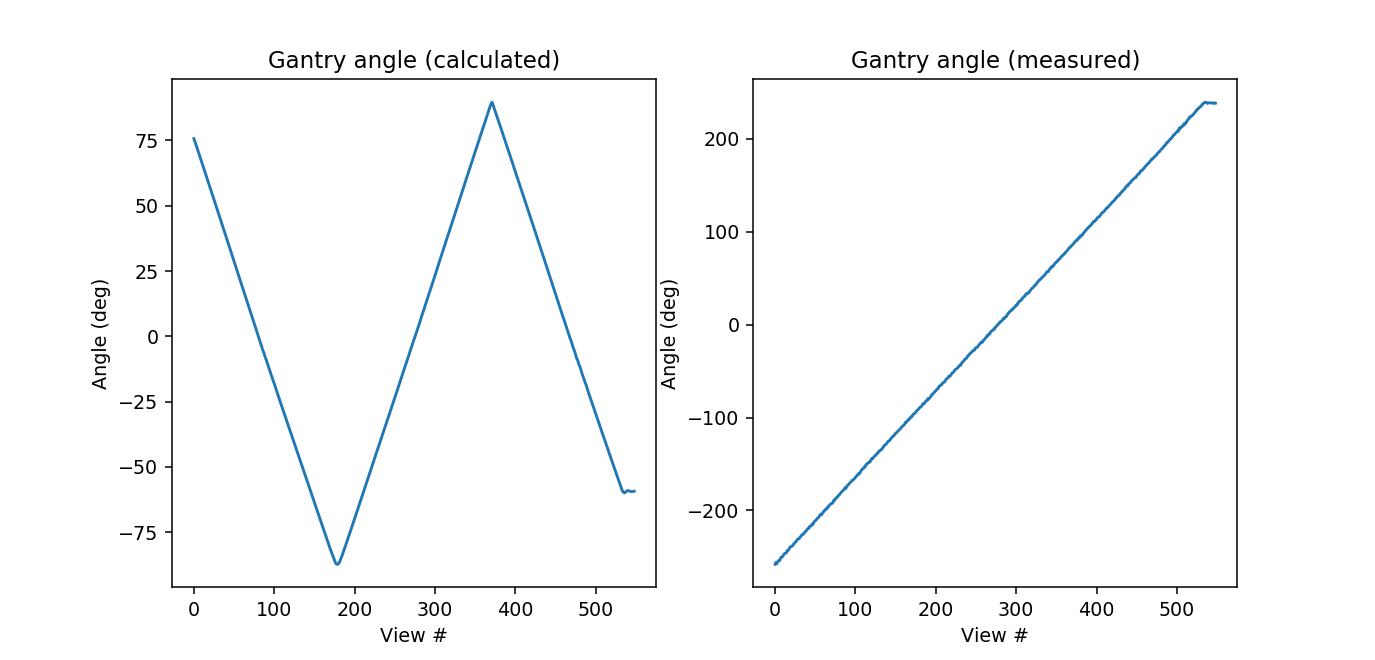

In [10]:
angles = np.zeros([image_points.shape[0]])
sdd = np.zeros([image_points.shape[0]])

for i in range(image_points.shape[0]):
    Angle, Source, t, c = obj.li_method(model_points_2, image_points[i, :, :])
    angles[i] = Angle[1]
    sdd[i] = Source[2] * 0.32

fig = plt.figure()
ax = fig.add_subplot(121)    
    
ax.plot(np.arange(image_points.shape[0]), angles)
ax.set_title('Gantry angle (calculated)')
ax.set_xlabel('View #')
ax.set_ylabel('Angle (deg)')

ax2 = fig.add_subplot(122)
ax2.plot(np.arange(image_points.shape[0]), store['/adora/date_{date}/scan{scan_number}/angles'.format(date=date, scan_number=scan_number)].angle.values)
ax2.set_title('Gantry angle (measured)')
ax2.set_xlabel('View #')
ax2.set_ylabel('Angle (deg)')

show()

Note that the angle values aren't the same for two reasons:

 - The coordinate systems are different (gantry coord system vs model phantom coord system)
 - There appears to be a 90 degree issue in the fitting code.

Next, let's examine source to detector distance...

<IPython.core.display.Javascript object>


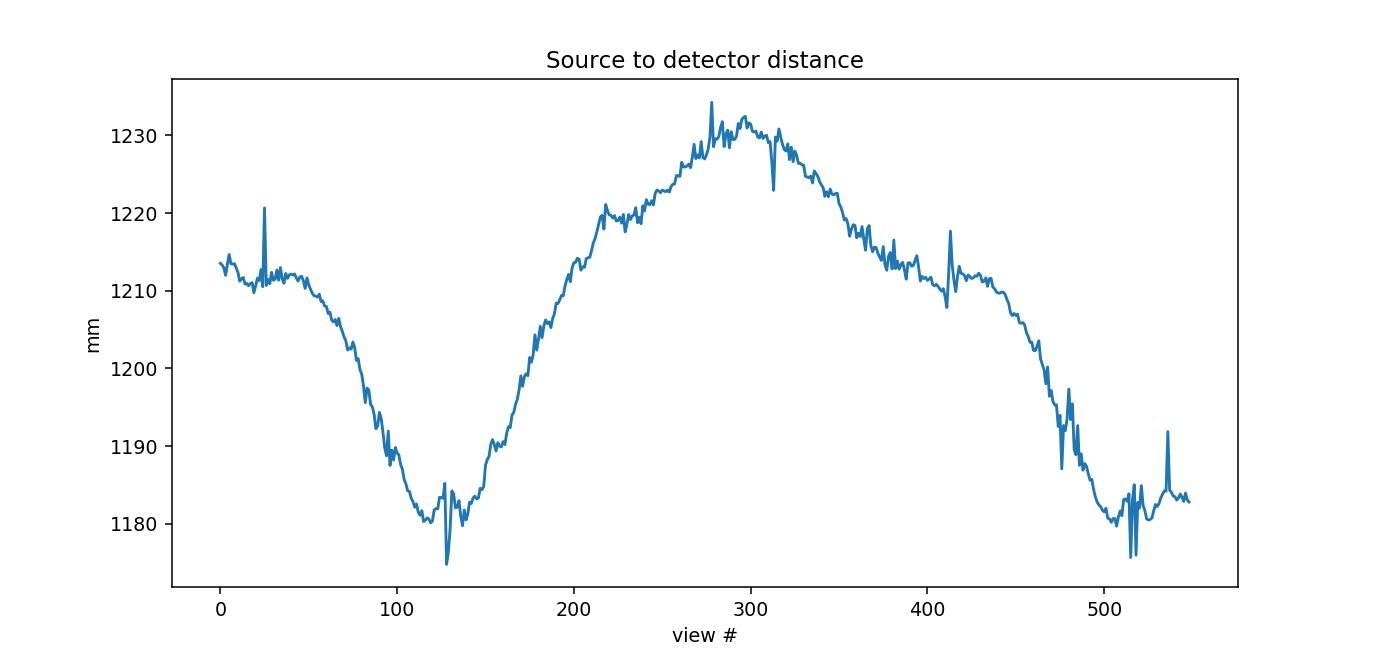

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)    
    
ax.plot(np.arange(image_points.shape[0]), sdd)
ax.set_title('Source to detector distance')
ax.set_xlabel('view #')
ax.set_ylabel('mm')
show()

### U,V offset calculation

Next, let's determine how far the 10th BB deviates from an ideal sine-wave.

<IPython.core.display.Javascript object>


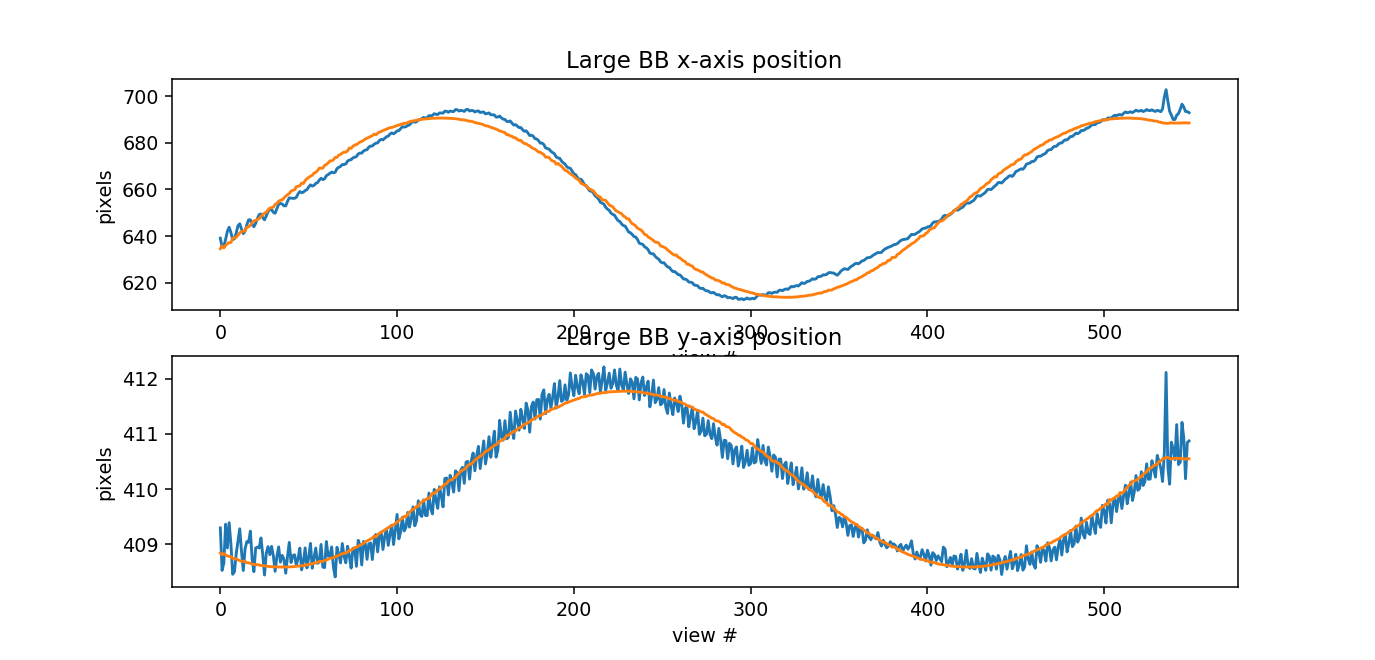

Average U0: 652.18 pixels


In [12]:
import numpy as np
from scipy.optimize import leastsq
import scipy

scan_number = 1 

image_points = store['/adora/date_{date}/scan{scan_number}/XMALab/measured_points'.format(date=date, scan_number=scan_number)].values
shape = image_points.shape
image_points.shape = (shape[0], shape[1]//2, 2)
image_points = image_points[:, 9, :]

# angle data as determined by rpos
angles = store['/adora/date_{date}/scan{scan_number}/angles'.format(date=date, scan_number=scan_number)].angle.values

# guess at U0,V0 by averaging data
U0 = image_points[:, 0].mean()
V0 = image_points[:, 1].mean()

# guess at sin function amplitude
guess_U_std = image_points[:, 0].max() - image_points[:, 0].min()
guess_V_std = image_points[:, 1].max() - image_points[:, 1].min()

# phase is zero
guess_phase = 0.0

optimize_func1 = lambda t, *x: (x[0]*np.sin((t+x[1]) / 180. * np.pi) + x[2])
p_fit1, ret1 = scipy.optimize.curve_fit(optimize_func1, angles, image_points[:, 0], [guess_U_std, guess_phase, U0])
p_fit2, ret2 = scipy.optimize.curve_fit(optimize_func1, angles, image_points[:, 1], [guess_V_std, guess_phase, V0])

fig = plt.figure()
ax = fig.add_subplot(211)
ax.plot(image_points[:, 0])
data_fit = optimize_func1(angles, *p_fit1)
ax.plot(data_fit)
ax.set_title('Large BB x-axis position')
ax.set_xlabel('view #')
ax.set_ylabel('pixels')
U_deviation = data_fit - image_points[:, 0]

ax = fig.add_subplot(212)
ax.plot(image_points[:, 1])
data_fit = optimize_func1(angles, *p_fit2)
ax.plot(data_fit)
ax.set_title('Large BB y-axis position')
ax.set_xlabel('view #')
ax.set_ylabel('pixels')
V_deviation = data_fit - image_points[:, 1]

uv_deviations = pd.DataFrame(np.array([U_deviation, V_deviation]).T, columns=['ΔU', 'ΔV'])
store['/adora/date_{date}/scan{scan_number}/uv_deviations'.format(date=date, scan_number=scan_number)] = uv_deviations
store.flush()

show()

#print("Average U0: {:.2f} pixels".format(store['/adora/date_20170628/bright'].shape[1] - p_fit1[2]))
print("Average U0: {:.2f} pixels".format(p_fit1[2]))

Okay, this result is a bit worrying:  The top plot shows that the U0 shift as a function of time clearly deviates from a sin function.  The bottom  plot looks okay though.  The bottom chart seems to validate the code though - I think the fit is working fine.  The recon engine can take this offset values directly, but to satisfy David, let's show pre/post corrected sinograms.  In the image, below, raw data is on the left.  Corrected data is on the right.  Notice that the oscillations at top and bottom have been largely fixed.  Also notice the change in particularly the right side of the image.

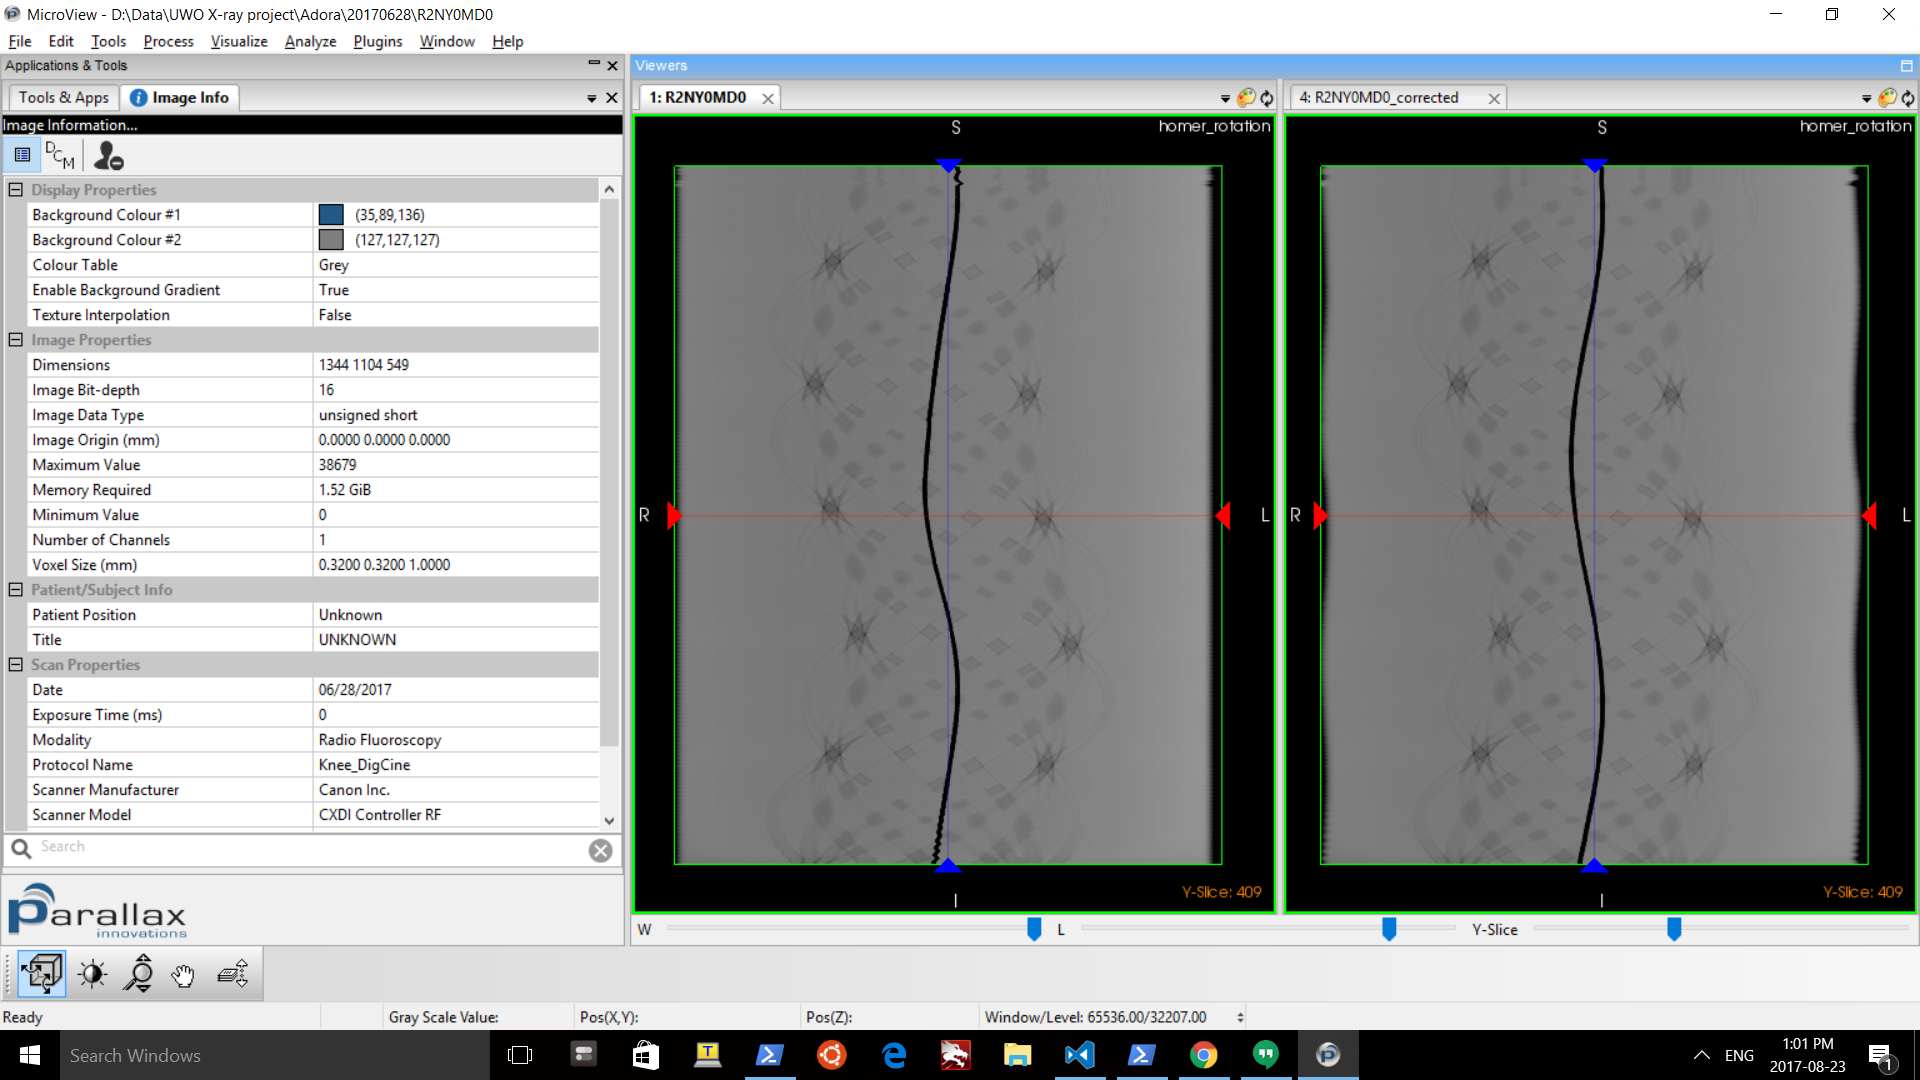

In [13]:
Image('https://s3.amazonaws.com/parallax-adora/Adora/20170628/pre_vs_post_corrected_image.png')

### Experiment with reconstruction of view through large BB

These images are from reconstructions done on my other laptop.  In the first image, if you look carefully, you can see 8 intersections with the phantom body itself plus the large BB near the center.  This actually isn't so bad an image.

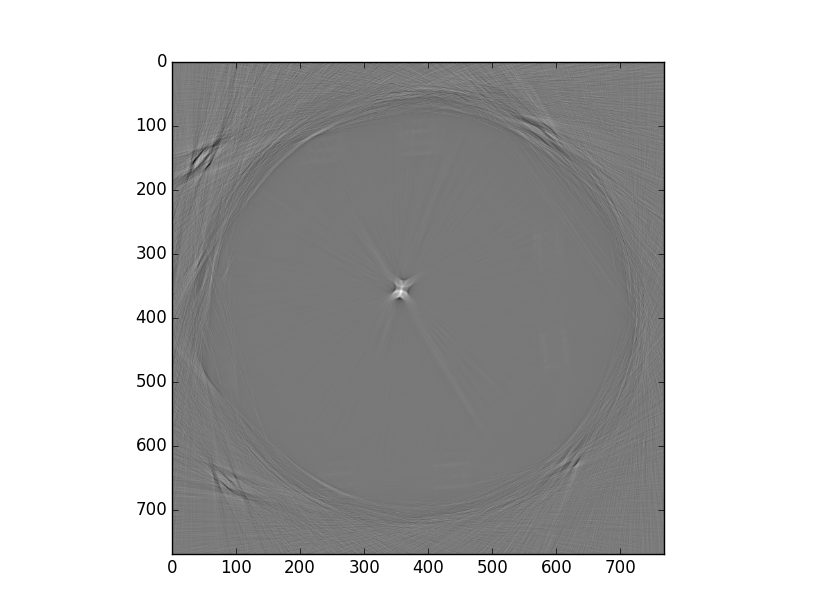

In [14]:
# U0=654.9, V0=575.41 -- The U0 comes directly from Yang2006, the V0 value is flipped about y-axis
Image('https://s3.amazonaws.com/parallax-adora/Adora/20170628/Reconstructions/recon_1_u0%3D654.9%2Cv0%3D575.41.png', width=500)

Next, let's show a reconstruction on the corrected image data - I won't apply U,V shifting in recon code but instead use the shifted image data.

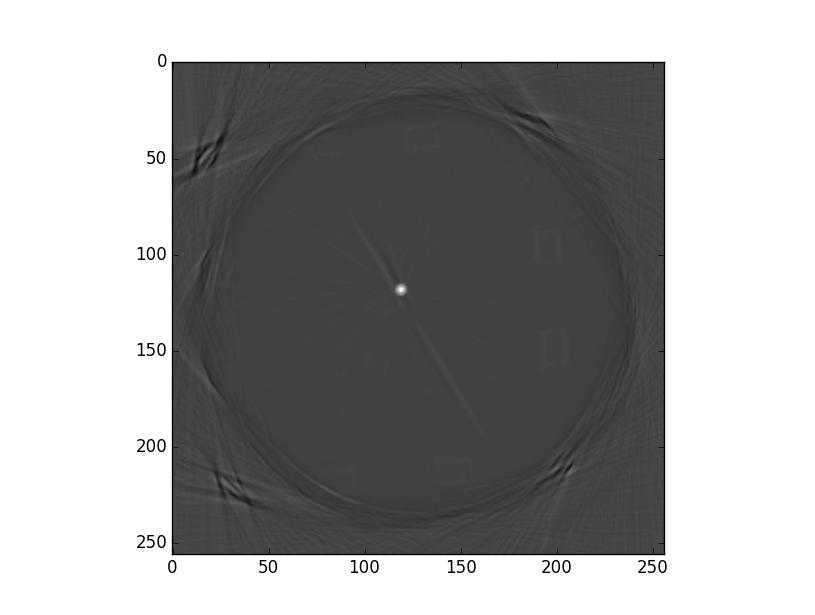

In [15]:
# U0=654.9, V0=575.41 -- The U0 comes directly from Yang2006, the V0 value is flipped about y-axis
# SDD=1212.978 (Yang), SOD=935.313 (Yang)

#
#  This is an intermediate result...
#

Image('https://s3.amazonaws.com/parallax-adora/Adora/20170628/Reconstructions/recon_2_u0%3D654.9%2Cv0%3D575.41.png', width=500)


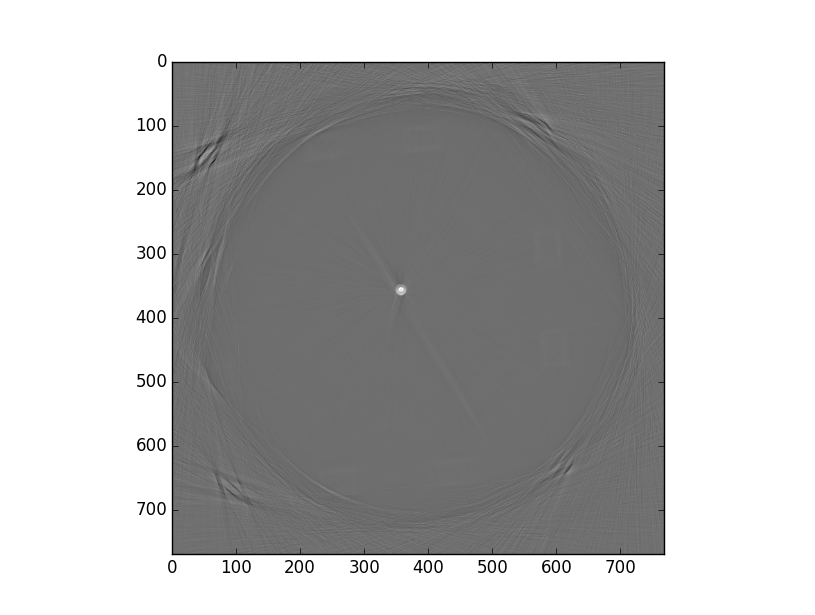

In [16]:
#
#  and this is the final result -- Note that there's still an obvious center of rotation problem if you zoom in
#

Image('https://s3.amazonaws.com/parallax-adora/Adora/20170628/Reconstructions/recon_3_u0%3D654.9%2Cv0%3D575.41.png', width=500)

Huh.  This works.  David's going to rub my nose in this...

I should mention that a major breakthrough occurred when I realized that angle data appears to be reversed when compared with the order of DICOM slices.  Also, I had to avoid 16-bit overflow issues by throwing in an arbitrary divisor (akin to the ~10k value used in Locus/eXplore data).

### Test BB tracking code

Okay, now let's run a BB detection on first set of DICOM data recorded on 2017-06-28.  We no longer really need this code since XMALabs works so well.

In [17]:
# create a widget to control which scan to investigate

options = ['Scan {}'.format(i+1) for i in range(3)]

scan_number = widgets.Dropdown(
    options=options,
    value='Scan 1',
    description='Scan Number:',
    disabled=False,
)

display(scan_number)

# create an object finder
obj = adora_bb_finder.BBFinder()

folder = 'D:\\Data\\UWO X-ray project\\Adora\\20170628'
filenames = os.listdir(folder)[-3:]
filename = filenames[0]

obj.set_dicom_filename(os.path.join(folder, filename))

# this line will take a bit of time to execute as it imports ~1GB of data ...
image, ds = obj.read_dicom_image(os.path.join(folder, filename))

A Jupyter Widget

In [18]:
# okay, track all slices

progress = IntProgress(min=0, max=obj._image.shape[0]-1, value=0)
progress.bar_style = 'info'
progress.bar_style = 'success'

label = HTML()
label.value = "Detecting large BB on all slices..."
box = VBox(children=[label, progress])
display(box)

label2 = '/adora/date_{}/scan1/large_BB_points'.format(ds.SeriesDate, int(ds.InstanceNumber) - 2)

if label2 not in store:
    obj.setup_large_bb_detector()
    points = obj.track_fiducials(progress=progress)
    points = points[0, :, :]
else:
    points = store[label2].values
    
progress.value = obj._image.shape[0]-1
label.value = "Done!"

# save points back to hdf5 file
if label2 not in store:
    store[label2] = points
    store.flush()


A Jupyter Widget

TypeError: cannot create a storer if the object is not existing nor a value are passed

In [ ]:
# display results
from ipywidgets import widgets
from IPython.display import display, clear_output

%matplotlib notebook

# display first slice
#plt.figure(figsize=(8, 8))
fig = plt.figure(figsize=(9,6))
axe = fig.add_subplot(211)
img = axe.imshow(obj._image[0, :, :], cmap='gray')
line1 = axe.plot(points[:, 0], points[:, 1])
line2 = axe.plot(points[0, 0], points[0, 1], 'ro')

axe2 = fig.add_subplot(212)
line3 = axe2.plot(points[:, 0])
line4 = axe2.plot([0, points[:, 0].min()], [1, points[:, 0].max()], 'ro')
axe2.set_xlabel('view #')
axe2.set_ylabel('BB position (x-axis, pixels)')


def update_results(i):
    #fig.clf()
    img.set_data(obj._image[i, :, :])
    img.autoscale()
    ret = axe.set_title('slice {}'.format(i))
    line1[0].set_data(points[:, 0], points[:, 1])
    line2[0].set_data(points[i, 0], points[i, 1])
    line4[0].set_data(i, points[i, 0])
    axe2.set_ylim([640,740])  # why is this needed?
#    ret = display(fig)
    
ret = widgets.interact(update_results, i=(0, obj._image.shape[0]-1))

Clearly, the plot above shows a non-sinusoidal trend.  Actually, this could be a magnification effect.  I also see that the centroid could be improved upon, but this is a secondary concern.

# 9-point BB-tracking and Calibration

Next, we'll track 9 medium-sized BB's in order to calibrate scanner params.

In [ ]:
%matplotlib notebook

# the `medium` setup is for the 9-BB phantom
obj.setup_medium_bb_detector()

# find 9 BBs, then display results
_slice, keypoints = obj.process_slice(0)
obj.show_slice(0, keypoints)

In [ ]:
points = np.array([k.pt for k in keypoints])
means = points[:,1].mean()
unique_bb_index = np.abs(points[:, 1] - means).argmin()
unique_bb_index

top_bb_indices = np.where(points[:, 1] < points[unique_bb_index, 1])[0]
bottom_bb_indices = np.where(points[:, 1] > points[unique_bb_index, 1])[0]
ss = np.linalg.norm(points - points[unique_bb_index, :], axis=1).argsort()
upper_point_closest_to_unique = ss[1]
lower_point_closest_to_unique = bottom_bb_indices[np.linalg.norm(points[bottom_bb_indices] - points[unique_bb_index,  :], axis=1).argsort()[0]]



print(unique_bb_index, upper_point_closest_to_unique, lower_point_closest_to_unique)

In [ ]:
# okay, track all slices
from ipywidgets import IntProgress, widgets, HTML, VBox

progress = IntProgress(min=0, max=obj._image.shape[0]-1, value=0)
progress.bar_style = 'info'
progress.bar_style = 'success'

label = HTML()
label.value = "Detecting medium BB on all slices..."
box = VBox(children=[label, progress])
display(box)

points = obj.track_fiducials(progress=progress, debug=True)
label.value = "Done!"